# Contour Plot of Prediction of Convection Diffusion Problem


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np

In [ ]:
from src.utils.plot_prediction import plot_contour
from src.data.diffusion_dataset import r, u
from src.nn.pde import diffusion_operator
from src.utils.logger import Logging

Plot the best and second best models.


In [ ]:
GRBF_DIST = "./model/a1/diffusion_grbf_a1.pth"
TANH_PARAM_DIST = "./model/a2/diffusion_tanh_trainable_a2.pth"

SOLVER_TO_MODULE = {
    "grbf": "src.nn.grbf",
    "KAN_Jacobi": "src.nn.jacobi",
    "KAN_tanh_param": "src.nn.tanh_param",
    "KAN_Chebyshev": "src.nn.chebyshev",
    "MLP": "src.nn.tanh_parameterized",
    "MLP2": "src.nn.tanh",
}

RESULT = "result/diffusion"

Create logger


In [ ]:
TEST_CHECKPOINT_PATH = os.path.join("result/diffusion")
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()
logger.print(f"Result directory {model_dirname}")

INFO:src.utils.logger:Result directory /home/ubuntu/afrah/code/pinn_learnable_activation/result/diffusion/2024-10-05_18-30-29-263918


## Generate Testing Data


In [23]:
NUM_OF_POINTS = 50

dom_coords = torch.tensor(
    [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float32, device="cpu"
)

time_ = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)
xfa = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)

yfa = (
    torch.linspace(dom_coords[0, 2], dom_coords[1, 2], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)


time_, xfa, yfa = torch.meshgrid(time_.squeeze(), xfa.squeeze(), yfa.squeeze())
X_star = torch.hstack(
    (
        time_.flatten().unsqueeze(1),
        xfa.flatten().unsqueeze(1),
        yfa.flatten().unsqueeze(1),
    )
).to("cpu")

u_star = u(X_star).to("cpu")
f_star = r(X_star).to("cpu")

## Load and Test Model


In [ ]:
model_list = {
    "grbf": GRBF_DIST,
    "tanh_param": TANH_PARAM_DIST,
}

model_dict = {
    "grbf": [],
    "tanh_param": [],
}
for key, model in model_list.items():
    state = torch.load(model)
    config = state.get("config", {})
    solver = config.get("solver")

    logger.print("_summary of the model _")
    logger.print("model path:", model)
    logger.print("model configuration:")

    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    model.eval()

    [u_pred, f_pred] = diffusion_operator(
        model, X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3]
    )

    error_u = torch.norm(u_pred - u_star, 2) / torch.norm(u_star, 2) * 100
    error_f = torch.norm(f_pred - f_star, 2) / torch.norm(f_star, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

    model_dict[key] = [u_pred, f_pred]
    logger.print("***********************************************************")

INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a1/diffusion_grbf_a1.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:Relative L2 error_u: 1.16e+01
INFO:src.utils.logger:Relative L2 error_f: 2.08e+00
INFO:src.utils.logger:***********************************************************
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:../../model/a2/diffusion_tanh_trainable_a2.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:Relative L2 error_u: 1.15e+01
INFO:src.utils.logger:Relative L2 error_f: 7.64e+00
INFO:src.utils.logger:***********************************************************


## Plot Test Result


In [25]:
tstep = NUM_OF_POINTS
xstep = NUM_OF_POINTS
ystep = NUM_OF_POINTS


X = X_star.cpu().detach().numpy()
exact_velocity = u_star.cpu().detach().numpy()
exact_force = f_star.cpu().detach().numpy()

grbf_velocity = model_dict["grbf"][0].cpu().detach().numpy()
grbf_force = model_dict["grbf"][1].cpu().detach().numpy()
tanh_param_velocity = model_dict["tanh_param"][0].cpu().detach().numpy()
tanh_param_force = model_dict["tanh_param"][1].cpu().detach().numpy()


xf = xfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[0,:]
yf = yfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[:,0]

exact_velocity = exact_velocity.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_force = exact_force.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]

grbf_velocity = grbf_velocity.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
grbf_force = grbf_force.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
tanh_param_velocity = tanh_param_velocity.reshape(
    tstep, xstep, ystep
)  # .reshape(100,100)[0,:]
tanh_param_force = tanh_param_force.reshape(
    tstep, xstep, ystep
)  # .reshape(100,100)[0,:]

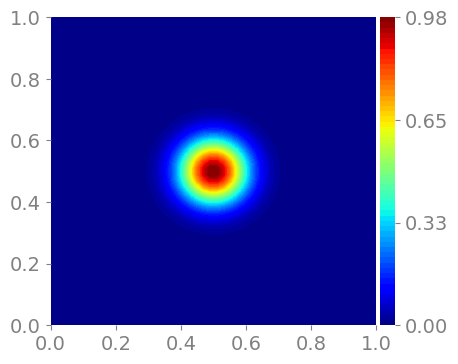

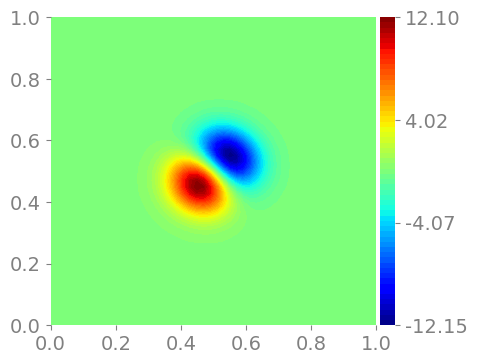

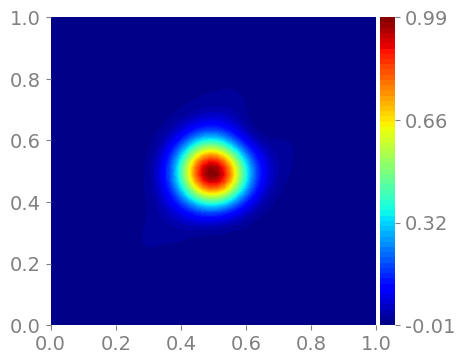

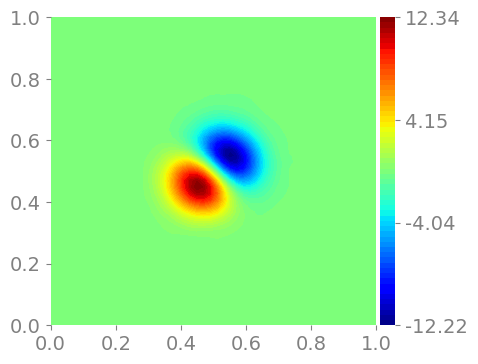

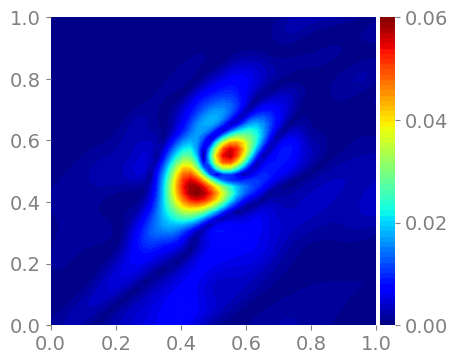

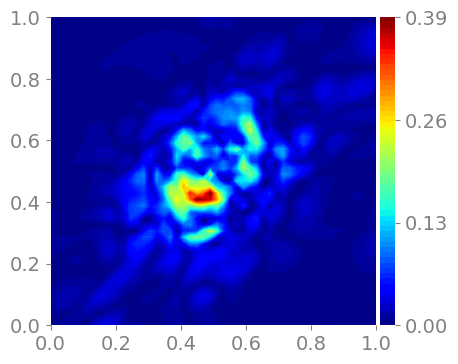

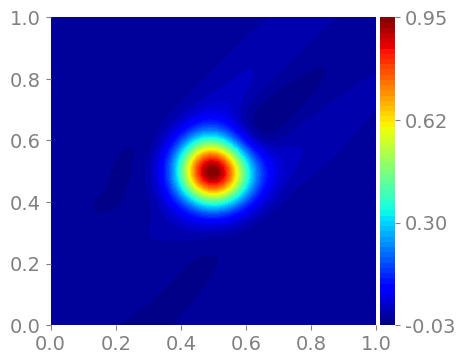

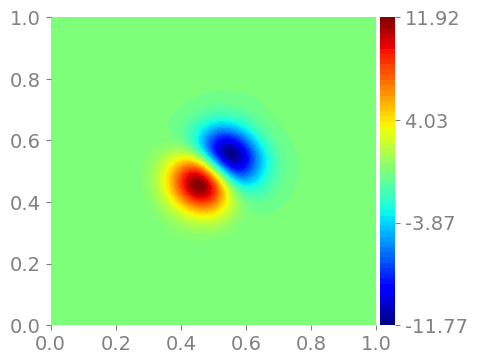

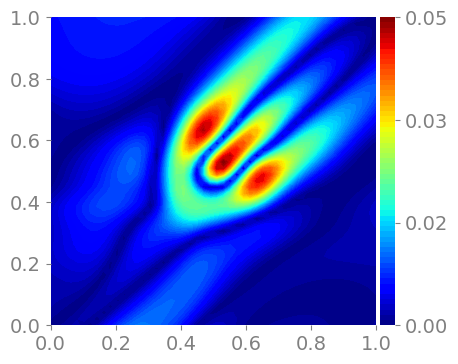

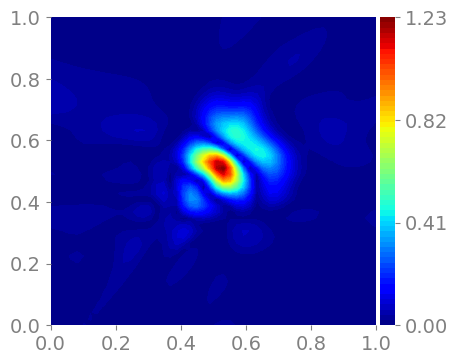

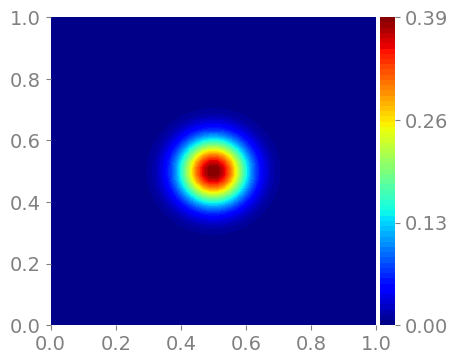

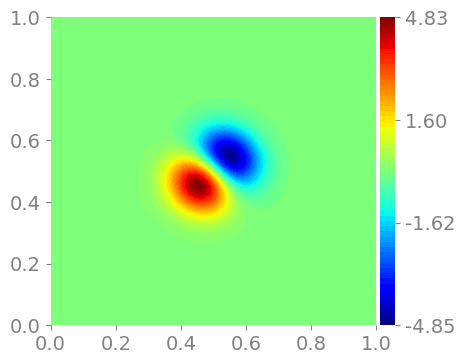

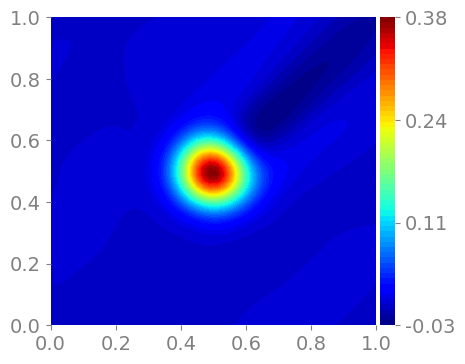

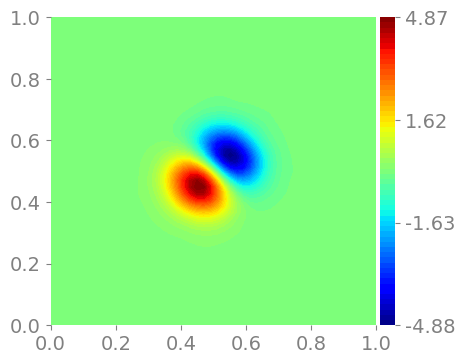

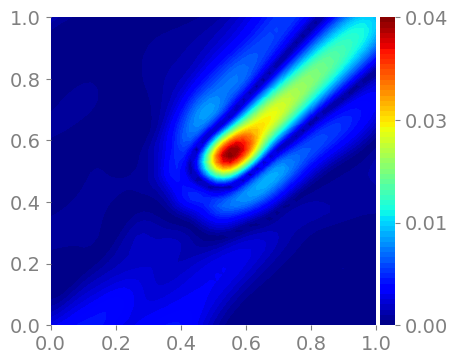

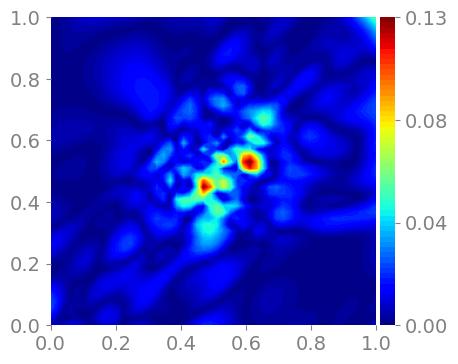

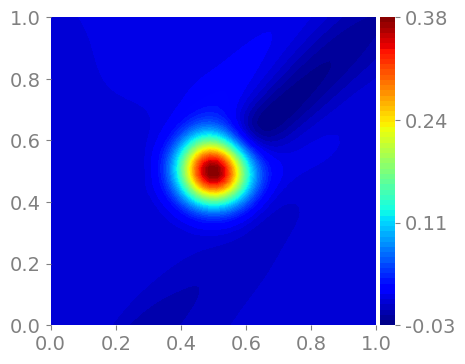

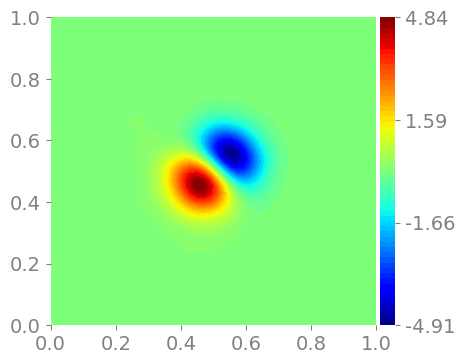

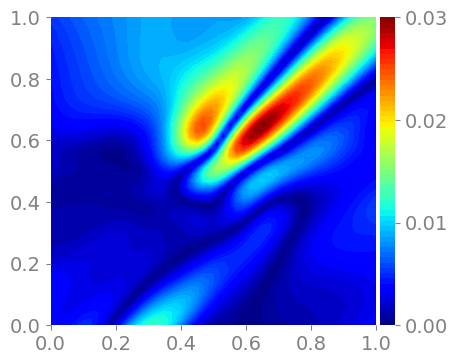

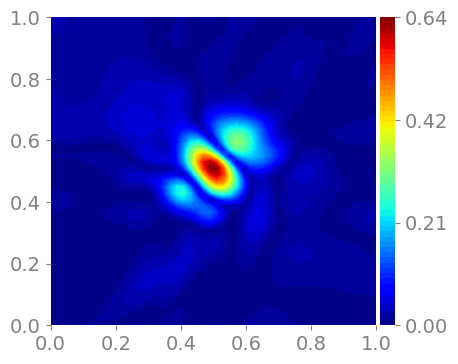

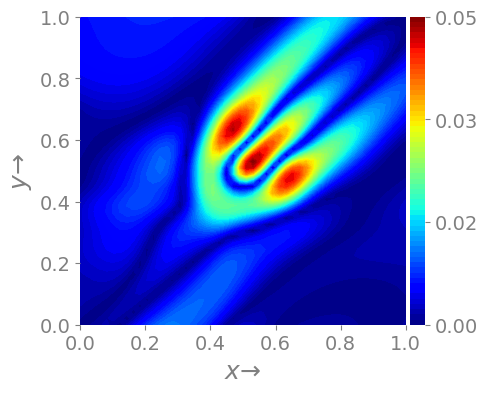

In [ ]:
grbf_error_velocity = np.abs(grbf_velocity - exact_velocity)
tanh_param_error_velocity = np.abs(tanh_param_velocity - exact_velocity)
grbf_error_force = np.abs(grbf_force - exact_force)
tanh_param_error_force = np.abs(tanh_param_force - exact_force)


data = [
    exact_velocity,
    exact_force,
    grbf_velocity,
    grbf_force,
    grbf_error_velocity,
    grbf_error_force,
    tanh_param_velocity,
    tanh_param_force,
    tanh_param_error_velocity,
    tanh_param_error_force,
]

titles = [
    "exact_velocity",
    "exact_force",
    "grbf_velocity",
    "grbf_force",
    "grbf_error_velocity",
    "grbf_error_force",
    "tanh_param_velocity",
    "tanh_param_force",
    "tanh_param_error_velocity",
    "tanh_param_error_force",
]

plot_xy = False

time_steps = [0, 45]
xy_labels = [r"$x→$", r"$y→$"]
index = 0

x = xf[0, :, :][..., None]
y = yf[0, :, :][..., None]

X = np.concatenate([x, y], axis=-1)
for time_step in time_steps:
    for index, (title, z) in enumerate(zip(titles, data)):
        file_name = os.path.join(model_dirname, f"{index}_{title}_time{time_step}.png")
        # plot_xy = index == 16
        fig = plot_contour(X, z[time_step, :, :], file_name, plot_xy, xy_labels)

# draw t, x label
file_name = os.path.join(
    model_dirname, f"{8}_{'tanh_param_error_velocity'}_time{0}.png"
)
fig = plot_contour(X, tanh_param_error_velocity[0, :, :], file_name, True, xy_labels)